In [346]:
import jax
jax.config.update('jax_default_matmul_precision', 'float32')
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
from transformer_lens import HookedTransformerConfig, HookedTransformer

from utils import cfg_from_tracr, load_tracr_weights

input_size = 7 # Length of sequences
vocab_size = 5  # Vocabulary size


vocab = {*range(vocab_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

tracr_model = compiling.compile_rasp_to_model(
    program=program,
    vocab=vocab,
    max_seq_len=input_size,
    compiler_bos="bos",
    mlp_exactness=100)

cfg = cfg_from_tracr(tracr_model)
model = HookedTransformer(cfg)
# model = load_tracr_weights(model, tracr_model, cfg) # TODO get this to work

In [347]:
import torch as tc
import itertools
def get_all_sequences(max_seq_len, vocab_size):
    # Generate all possible sequences of length n with vocabulary size m
    sequences = itertools.product(range(vocab_size), repeat=max_seq_len)
    sequences = [tc.tensor(seq) for seq in sequences]
    return sequences
sequences = get_all_sequences(input_size, vocab_size)
print(f"generated {len(sequences)} sequences of length {input_size} with vocabulary size {vocab_size}")

train_test_split = 0.01
train_size = int(len(sequences) * train_test_split)
# train_sequences = sequences[:train_size] # this is a bad way to split the data → we need to split it randomly
# test_sequences = sequences[train_size:] 
import random
random.shuffle(sequences)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]
print(f"train size: {len(train_sequences)}")
print(f"test size: {len(test_sequences)}")
print(f"train sequences: {train_sequences}")

generated 78125 sequences of length 7 with vocabulary size 5
train size: 781
test size: 77344
train sequences: [tensor([0, 0, 0, 4, 3, 3, 1]), tensor([2, 2, 0, 2, 4, 3, 0]), tensor([3, 4, 3, 3, 1, 4, 2]), tensor([0, 2, 1, 0, 3, 4, 0]), tensor([0, 4, 3, 2, 1, 3, 4]), tensor([2, 1, 1, 4, 1, 0, 1]), tensor([4, 3, 1, 3, 3, 2, 3]), tensor([1, 3, 3, 0, 3, 1, 1]), tensor([2, 3, 2, 1, 1, 2, 0]), tensor([4, 1, 4, 0, 2, 0, 4]), tensor([3, 2, 3, 0, 1, 0, 2]), tensor([2, 1, 0, 2, 0, 3, 0]), tensor([3, 3, 0, 3, 4, 3, 1]), tensor([1, 4, 1, 0, 3, 2, 0]), tensor([2, 0, 3, 4, 4, 0, 2]), tensor([3, 1, 2, 4, 2, 2, 3]), tensor([3, 0, 0, 2, 2, 2, 3]), tensor([3, 4, 1, 3, 2, 1, 4]), tensor([4, 0, 0, 2, 2, 1, 0]), tensor([3, 1, 0, 1, 0, 4, 4]), tensor([3, 0, 0, 0, 4, 4, 2]), tensor([1, 0, 2, 3, 1, 0, 1]), tensor([0, 0, 4, 0, 1, 2, 1]), tensor([2, 4, 4, 1, 0, 3, 2]), tensor([4, 2, 2, 4, 4, 3, 0]), tensor([2, 3, 1, 0, 1, 1, 2]), tensor([4, 0, 2, 3, 2, 4, 4]), tensor([0, 4, 1, 1, 0, 0, 3]), tensor([2, 4, 3, 4, 

In [348]:
# from train import loss_function, accuracy_function

import torch as tc

def loss_function(outputs, targets):
    return tc.nn.functional.cross_entropy(outputs, targets, reduce=True, reduction='mean')

def accuracy_function(outputs, targets):
    return (outputs.argmax(1) == targets).float().mean()

In [349]:
train_loader = tc.utils.data.DataLoader(train_sequences, batch_size=256, shuffle=True)
inputs = next(iter(train_loader))
targets = tc.sort(inputs, dim=1).values
print(inputs.shape)
print(targets.shape)
print(inputs)

torch.Size([256, 7])
torch.Size([256, 7])
tensor([[2, 4, 2,  ..., 1, 3, 4],
        [0, 0, 3,  ..., 3, 4, 3],
        [2, 2, 2,  ..., 4, 3, 1],
        ...,
        [0, 1, 1,  ..., 2, 4, 0],
        [0, 0, 3,  ..., 1, 4, 4],
        [3, 3, 4,  ..., 0, 4, 0]])


In [350]:
model.to('cpu')
inputs = next(iter(train_loader))
outputs, cache = model.run_with_cache(inputs)
print(outputs.shape)
# output shape is (batch_size, vocab_size, input_size) but we need (batch_size, input_size, vocab_size)
outputs = outputs.permute(0, 2, 1)
accuracy = accuracy_function(outputs, targets) 
loss = loss_function(outputs, targets)
print(f"initial accuracy: {accuracy.item()}")
print(f"initial loss: {loss.item()}")

Moving model to device:  cpu
torch.Size([256, 7, 5])
initial accuracy: 0.1897321492433548
initial loss: 1.6634982824325562


In [356]:
from tqdm import tqdm, trange

train_loader = tc.utils.data.DataLoader(train_sequences, batch_size=256, shuffle=True)
test_loader = tc.utils.data.DataLoader(test_sequences, batch_size=256, shuffle=True)
model.to('cpu')
model.train()
optimizer = tc.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
n_epochs = 10000

from tqdm import trange
for epoch in trange(n_epochs, desc="Training Epochs", unit="epoch"):
# for epoch in range(n_epochs):
    # for batch_idx, inputs in enumerate(tqdm(train_loader)):
    for batch_idx, inputs in enumerate(train_loader):
        targets = tc.sort(inputs, dim=1).values
        optimizer.zero_grad()
        outputs, cache = model.run_with_cache(inputs)
        outputs = outputs.permute(0, 2, 1)

        train_loss = loss_function(outputs, targets)
        train_loss.backward()
        optimizer.step()
        train_accuracy = accuracy_function(outputs, targets) 

        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy.item())

        with tc.no_grad():
            model.eval()
            test_inputs = next(iter(test_loader))
            test_targets = tc.sort(test_inputs, dim=1).values
            test_outputs, cache = model.run_with_cache(test_inputs)
            test_outputs = test_outputs.permute(0, 2, 1)
            test_loss = loss_function(test_outputs, test_targets)
            test_accuracy = accuracy_function(test_outputs, test_targets) 

            test_losses.append(test_loss.item())
            test_accuracies.append(test_accuracy.item())
    # print(f"epoch {epoch}: train accuracy: {train_accuracy.item()}, test accuracy: {test_accuracy.item()}")
    # print(f"epoch {epoch}: train loss: {train_loss.item()}, test loss: {test_loss.item()}")
    # update the above print statement to use tqdm →
    # update dynamic tqdm progress bar
    trange.set_postfix(train_loss=train_loss, train_acc=train_accuracy, test_loss=test_loss, test_acc=test_accuracy)
    trange.update(1)
    


# train_accuracy = tc.tensor(train_accuracies).mean()
# train_loss = tc.tensor(train_losses).mean()
# test_accuracy = tc.tensor(test_accuracies).mean()
# test_loss = tc.tensor(test_losses).mean()


print(f"final accuracy: {train_accuracy.item()}")
print(f"final loss: {train_loss.item()}")
print(f"final test accuracy: {test_accuracy.item()}")
print(f"final test loss: {test_loss.item()}")



Moving model to device:  cpu


Training Epochs:   0%|          | 0/10000 [00:00<?, ?epoch/s]/Users/leonardbereska/miniconda3/envs/sortinterp/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Training Epochs:   0%|          | 0/10000 [00:00<?, ?epoch/s]


AttributeError: 'function' object has no attribute 'set_postfix'

[1.6078746318817139, 1.5851616859436035, 1.5627309083938599, 1.5406813621520996, 1.5190223455429077, 1.497645616531372, 1.4764152765274048, 1.4551798105239868, 1.4338544607162476, 1.412236213684082, 1.390177845954895, 1.3676292896270752, 1.3445607423782349, 1.32102370262146, 1.2970211505889893, 1.2724155187606812, 1.2471214532852173, 1.2211436033248901, 1.1944390535354614, 1.167090892791748, 1.1392128467559814, 1.1109471321105957, 1.0824414491653442, 1.0538039207458496, 1.0252829790115356, 0.9969605207443237, 0.9690388441085815, 0.9417055249214172, 0.9149499535560608, 0.8888196349143982, 0.8634271621704102, 0.8387510776519775, 0.814617395401001, 0.7908356785774231, 0.7673622369766235, 0.7440566420555115, 0.7209145426750183, 0.6980963945388794, 0.675725519657135, 0.6538617014884949, 0.6325878500938416, 0.6120242476463318, 0.5922998189926147, 0.5732318758964539, 0.5546780824661255, 0.5366862416267395, 0.5190597176551819, 0.5015365481376648, 0.4840726852416992, 0.46648168563842773, 0.4485

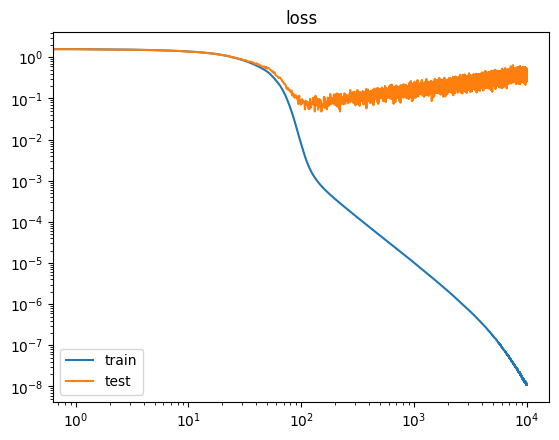

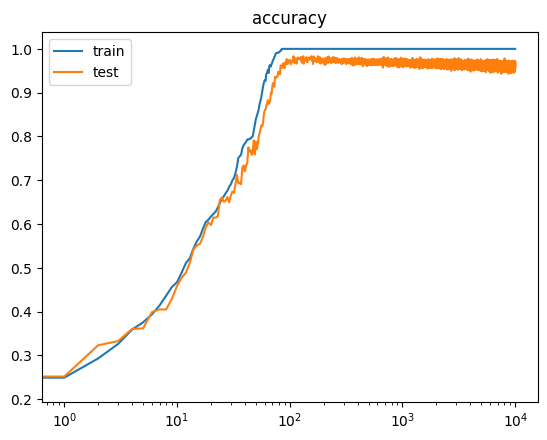

In [339]:
# plot loss and accuracy (log scale)
import matplotlib.pyplot as plt

print(train_losses)
print(test_losses)

# plot train and test loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.yscale('log')
plt.xscale('log')
plt.title('loss')
plt.legend(['train', 'test'])
plt.show()


# plot train and test accuracy
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.xscale('log')
plt.title('accuracy')
plt.legend(['train', 'test'])
plt.show()


In [340]:
# evaluate on test set
test_loader = tc.utils.data.DataLoader(test_sequences, batch_size=256, shuffle=True)
model.eval()
losses = []
accuracies = []
for i, inputs in enumerate(tqdm(test_loader)):
    targets = tc.sort(inputs, dim=1).values
    outputs, cache = model.run_with_cache(inputs)
    outputs = outputs.permute(0, 2, 1)
    loss = loss_function(outputs, targets)
    accuracy = accuracy_function(outputs, targets)
    losses.append(loss.item())
    accuracies.append(accuracy.item())
loss = tc.tensor(losses).mean()
accuracy = tc.tensor(accuracies).mean()
print(f"test loss: {loss.item()}")
print(f"test accuracy: {accuracy.item()}")


100%|██████████| 305/305 [00:05<00:00, 53.68it/s]

test loss: 0.3929339647293091
test accuracy: 0.9604988694190979


In [341]:
# experiment with different input output pairs
# do this for random inputs

errors = []
data_loader = tc.utils.data.DataLoader(test_sequences, batch_size=1, shuffle=True)
# data_loader = tc.utils.data.DataLoader(train_sequences, batch_size=1, shuffle=True)  # number of errors is 0
for _ in range(100):
    # inputs = tc.tensor([[random.randint(0, vocab_size-1) for _ in range(input_size)]])
    inputs = next(iter(data_loader))
    targets = tc.sort(inputs, dim=1).values
    logits, cache = model.run_with_cache(inputs)
    outputs = logits.argmax(2)
    logits = logits.permute(0, 2, 1)
    # if all the outputs are the same as the targets, then the model is correct
    if (outputs == targets).all():
        # print("correct")
        pass
    else:
        # print("incorrect")
        errors.append((inputs, targets, outputs, logits))
    # if outputs.argmax(1) == targets:
        # print("correct")
    # else:
        # print("incorrect")
print(f"number incorrectly sorted sequences: {len(errors)}")
# analyze the errors
# what is the model outputting wrong? compare for each error the position of the error and what should have been there

# for inputs, targets, outputs, logits in errors:
    # print("targets ", targets)
    # print("outputs ", outputs)
    # error_idx = (targets == outputs).nonzero()
    # print("error idx", error_idx)

# for inputs, targets, outputs, logits in errors:
#     plt.imshow(logits[0].detach().numpy())
#     plt.show()
#     print("inputs ", inputs)
#     print("targets ", targets)
#     print("outputs ", outputs)


number incorrectly sorted sequences: 28


inputs  tensor([[4, 1, 4, 4, 1, 3, 2]])
targets  tensor([[1, 1, 2, 3, 4, 4, 4]])
outputs  tensor([[0, 1, 2, 3, 3, 4, 4]])
model outputted 3 instead of 4 at position 4
[(3, 4), (0, 1), (4, 3), (1, 0), (3, 4), (4, 3), (1, 0), (4, 3), (1, 0), (4, 3), (4, 3), (3, 4), (4, 3), (1, 0), (0, 1), (2, 1), (4, 3), (3, 4), (0, 1), (4, 3), (3, 4), (4, 3), (0, 1), (0, 1), (3, 4), (0, 1), (3, 4), (0, 1)]


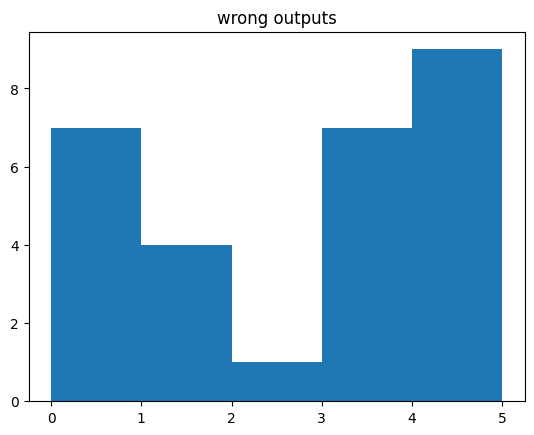

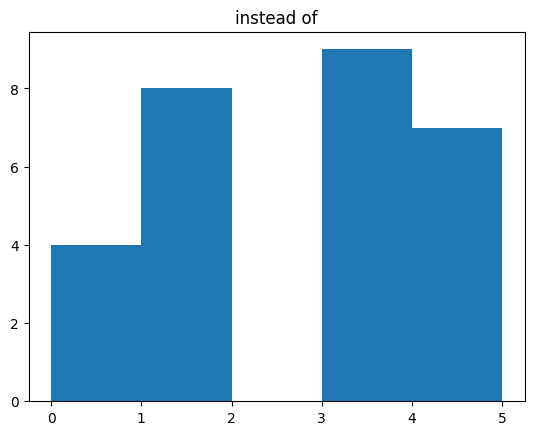

In [344]:
inputs, targets, outputs, logits = errors[0]
print("inputs ", inputs)
print("targets ", targets)
print("outputs ", outputs)

# what was wrong?
position = (targets != outputs).nonzero()[-1]
wrong_output = outputs[0, position][-1]
instead_of = targets[0, position][-1]
print(f"model outputted {wrong_output} instead of {instead_of} at position {position[-1]}")

# histogram of errors
error_positions = []
output_instead_of = []
for inputs, targets, outputs, logits in errors:
    position = (targets != outputs).nonzero()[-1]
    error_positions.append(position[-1])
    wrong_output = outputs[0, position][-1]
    instead_of = targets[0, position][-1]
    output_instead_of.append((wrong_output.item(), instead_of.item()))
# plt.hist(error_positions, bins=range(input_size+1))
# plt.title('error positions')
# plt.show()

# histogram of errors
print(output_instead_of)

wrong_outputs, instead_of = zip(*output_instead_of)

plt.hist(wrong_outputs, bins=range(vocab_size+1))
plt.title('wrong outputs')
plt.show()

plt.hist(instead_of, bins=range(vocab_size+1))
plt.title('instead of')
plt.show()



((3, 4), (0, 1), (4, 3), (1, 0), (2, 1))
(7, 7, 9, 4, 1)
Counter({(4, 3): 9, (3, 4): 7, (0, 1): 7, (1, 0): 4, (2, 1): 1})


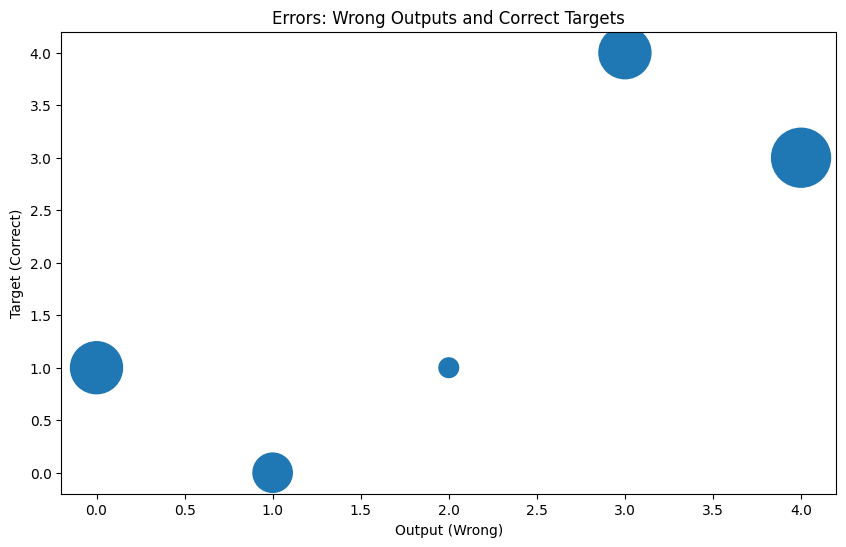

In [345]:
from collections import Counter
pair_counts = Counter(output_instead_of)

# Extract the unique pairs and their counts
unique_pairs, counts = zip(*pair_counts.items())
wrong_outputs, instead_of = zip(*unique_pairs)

print(unique_pairs)
print(counts)
print(pair_counts)

plt.figure(figsize=(10, 6))
x, y = zip(*unique_pairs)
sizes = [size*200 for size in counts]
plt.scatter(x, y, s=sizes)
plt.title('Errors: Wrong Outputs and Correct Targets')
plt.xlabel('Output (Wrong)')
plt.ylabel('Target (Correct)')
plt.show()

[50.0, 50.0, 110.0, 20.0, 20.0, 20.0, 10.0]

In [291]:
# save model with timestamp
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
tc.save(model.state_dict(), f'saved_models/{timestamp}.pt')
# save config
import pickle
with open(f'saved_models/{timestamp}.cfg', 'wb') as f:
    pickle.dump(cfg, f)

In [59]:
# load config
import pickle
with open(f'saved_models/{timestamp}.cfg', 'rb') as f:
    cfg = pickle.load(f)
# load model
model = HookedTransformer(cfg)
model.load_state_dict(tc.load(f'saved_models/{timestamp}.pt'))

<All keys matched successfully>